In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score,accuracy_score

In [2]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [3]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        #print(result)
        return np.sum(result)

In [4]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 90 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [5]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [6]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [7]:
df['swell'] = df['swell']# + df['weather_deterioration']

In [8]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [9]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [10]:
# # 음력 추가
# from korean_lunar_calendar import KoreanLunarCalendar
# from datetime import datetime

# def add_lunar_date(df):
#     calendar = KoreanLunarCalendar()
    
#     lunar_y = []
#     lunar_m = []
#     lunar_d = []
#     for y, m, d in zip (df['year'], df['month'], df['day']):
#         calendar.setSolarDate(y, m, d)
#         lunar_date = calendar.LunarIsoFormat()
#         lunar_y.append(int(lunar_date[:4]))
#         lunar_m.append(int(lunar_date[5:7]))
#         lunar_d.append(int(lunar_date[8:10]))
        
#     df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [11]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [12]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    #df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    #df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    #df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    
    #df.drop(['month', 'lunar_month'], axis=1, inplace=True)
    df.drop(['month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    #df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    #df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    #df.drop(['day', 'lunar_day'], axis=1, inplace=True)
    df.drop(['day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)
    df.drop(['week'],axis=1,inplace=True)

In [13]:
# %%time
# add_lunar_date(df)

In [14]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [15]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [16]:
s[s > 10].index.tolist()[0]

20170315

In [17]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [18]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [19]:
get_prev_date('20170101')

'2016123100'

In [20]:
get_today_from_07('20170101')

'2017010100'

In [21]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [22]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    #day = get_prev_date(d)
    #day = get_prev_date(d)
    day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031500 2017031600
2017121100 2017121200
2016113000 2016120100
2017033100 2017040100
2014102300 2014102400
2016102000 2016102100
2014051800 2014051900
2017021200 2017021300
2015071800 2015071900
2014070600 2014070700
2015062700 2015062800
2016083000 2016083100
2017102300 2017102400
2017101200 2017101300
2014122100 2014122200
2017091600 2017091700
2016012200 2016012300
2015040400 2015040500
2015011300 2015011400
2014092500 2014092600
2017060300 2017060400
2016122600 2016122700
2015121300 2015121400
2016030400 2016030500
2015111300 2015111400


600

In [23]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 92 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 non-null float64
21229_수온(°C)             34629 non-null float64
21229_습도(%)              33939 no

In [24]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [25]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

In [26]:
df.columns

Index(['climate', 'weather_deterioration', 'swell', '22453_수온(°C)',
       '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)', '22453_파주기(sec)',
       '22490_수온(°C)', '22490_최대파고(m)', '22490_유의파고(m)', '22490_평균파고(m)',
       '22490_파주기(sec)', '21229_GUST풍속 1(m/s)', '21229_GUST풍속(m/s)',
       '21229_기온(°C)', '21229_수온(°C)', '21229_습도(%)', '21229_유의파고(m)',
       '21229_최대파고(m)', '21229_파주기(sec)', '21229_파향(deg)', '21229_평균파고(m)',
       '21229_풍속(m/s)', '21229_풍속1(m/s)', '21229_풍향(deg)', '21229_풍향1(deg)',
       '21229_현지기압(hPa)', '22105_GUST풍속 1(m/s)', '22105_GUST풍속(m/s)',
       '22105_기온(°C)', '22105_수온(°C)', '22105_습도(%)', '22105_유의파고(m)',
       '22105_최대파고(m)', '22105_파주기(sec)', '22105_파향(deg)', '22105_평균파고(m)',
       '22105_풍속(m/s)', '22105_풍속1(m/s)', '22105_풍향(deg)', '22105_풍향1(deg)',
       '22105_현지기압(hPa)', '22106_GUST풍속 1(m/s)', '22106_GUST풍속(m/s)',
       '22106_기온(°C)', '22106_수온(°C)', '22106_습도(%)', '22106_유의파고(m)',
       '22106_최대파고(m)', '22106_파주기(sec)', '22106_파향(de

### 테스트 데이터 하나당 feature selection을 수행

In [27]:
test_date_hour = sorted(test_date_hour)
test_date_hour

['2014051807',
 '2014051808',
 '2014051809',
 '2014051810',
 '2014051811',
 '2014051812',
 '2014051813',
 '2014051814',
 '2014051815',
 '2014051816',
 '2014051817',
 '2014051818',
 '2014051819',
 '2014051820',
 '2014051821',
 '2014051822',
 '2014051823',
 '2014051900',
 '2014051901',
 '2014051902',
 '2014051903',
 '2014051904',
 '2014051905',
 '2014051906',
 '2014070607',
 '2014070608',
 '2014070609',
 '2014070610',
 '2014070611',
 '2014070612',
 '2014070613',
 '2014070614',
 '2014070615',
 '2014070616',
 '2014070617',
 '2014070618',
 '2014070619',
 '2014070620',
 '2014070621',
 '2014070622',
 '2014070623',
 '2014070700',
 '2014070701',
 '2014070702',
 '2014070703',
 '2014070704',
 '2014070705',
 '2014070706',
 '2014092507',
 '2014092508',
 '2014092509',
 '2014092510',
 '2014092511',
 '2014092512',
 '2014092513',
 '2014092514',
 '2014092515',
 '2014092516',
 '2014092517',
 '2014092518',
 '2014092519',
 '2014092520',
 '2014092521',
 '2014092522',
 '2014092523',
 '2014092600',
 '20140926

In [28]:
notna_df = df.loc[test_date_hour[:24]]['swell(t+1)']
notna_df

hour
2014051807    NaN
2014051808    NaN
2014051809    NaN
2014051810    NaN
2014051811    NaN
2014051812    NaN
2014051813    NaN
2014051814    NaN
2014051815    NaN
2014051816    NaN
2014051817    NaN
2014051818    NaN
2014051819    NaN
2014051820    NaN
2014051821    NaN
2014051822    NaN
2014051823    NaN
2014051900    NaN
2014051901    NaN
2014051902    NaN
2014051903    NaN
2014051904    NaN
2014051905    NaN
2014051906    0.0
Name: swell(t+1), dtype: float64

In [29]:
df.loc[:test_date_hour[3]]['swell(t+1)'].value_counts()

0.0    2929
1.0     286
Name: swell(t+1), dtype: int64

### col 중 20% 이상의 미싱벨류가 있는 경우 삭제

In [30]:
drop_features = ['swell(t+1)','swell','weather_deterioration','index','climate']

In [36]:
test_date = test_date_hour[0]
test_date

'2014051807'

In [37]:
all_df = df.loc[:test_date].iloc[:-1]#.drop(drop_features,axis=1)
all_df.tail(10)

,climate,weather_deterioration,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),22490_수온(°C),22490_최대파고(m),...,day_hour,year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,swell(t+1),index
hour,,,,,,,,,,,,,,,,,,,,,
2014051721,7.0,1,1.0,17.7,1.3,1.0,0.6,9.2,NaN,NaN,...,21,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349,1.0,3206
2014051722,7.0,1,1.0,17.3,1.5,1.2,0.7,9.2,NaN,NaN,...,22,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349,1.0,3207
2014051723,7.0,1,1.0,17.0,1.4,1.1,0.7,8.8,NaN,NaN,...,23,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349,1.0,3208
2014051800,7.0,1,1.0,17.0,1.6,1.2,0.7,9.1,NaN,NaN,...,0,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,1.0,3209
2014051801,7.0,1,1.0,17.0,1.5,1.1,0.7,8.7,NaN,NaN,...,1,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,1.0,3210
2014051802,5.0,1,1.0,16.7,1.8,1.2,0.8,8.6,NaN,NaN,...,2,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,1.0,3211
2014051803,5.0,1,1.0,16.5,1.5,1.2,0.7,8.6,NaN,NaN,...,3,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,1.0,3212
2014051804,5.0,1,1.0,16.4,1.2,1.1,0.7,8.4,NaN,NaN,...,4,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,1.0,3213
2014051805,5.0,1,1.0,16.3,1.2,1.0,0.6,8.2,NaN,NaN,...,5,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,1.0,3214


In [38]:
all_size = len(all_df)
col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.1)
possible_cols = col_df[col_df[0]==True].index.tolist()
possible_cols

['climate',
 'weather_deterioration',
 'swell',
 '22453_수온(°C)',
 '22453_최대파고(m)',
 '22453_유의파고(m)',
 '22453_평균파고(m)',
 '22453_파주기(sec)',
 '21229_GUST풍속 1(m/s)',
 '21229_기온(°C)',
 '21229_수온(°C)',
 '21229_습도(%)',
 '21229_유의파고(m)',
 '21229_최대파고(m)',
 '21229_파주기(sec)',
 '21229_파향(deg)',
 '21229_평균파고(m)',
 '21229_풍속1(m/s)',
 '21229_풍향1(deg)',
 '21229_현지기압(hPa)',
 '22105_GUST풍속 1(m/s)',
 '22105_기온(°C)',
 '22105_수온(°C)',
 '22105_습도(%)',
 '22105_유의파고(m)',
 '22105_최대파고(m)',
 '22105_파주기(sec)',
 '22105_파향(deg)',
 '22105_평균파고(m)',
 '22105_풍속1(m/s)',
 '22105_풍향1(deg)',
 '22106_GUST풍속 1(m/s)',
 '22106_기온(°C)',
 '22106_수온(°C)',
 '22106_습도(%)',
 '22106_유의파고(m)',
 '22106_최대파고(m)',
 '22106_파주기(sec)',
 '22106_파향(deg)',
 '22106_평균파고(m)',
 '22106_풍속1(m/s)',
 '22106_풍향1(deg)',
 '22106_현지기압(hPa)',
 'day_hour',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'weekday_sin',
 'weekday_cos',
 'swell(t+1)',
 'index']

In [39]:
possible_df = all_df[possible_cols].copy()
possible_df.tail()
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 2014010407 to 2014051806
Data columns (total 53 columns):
climate                  3216 non-null object
weather_deterioration    3216 non-null int64
swell                    3216 non-null float64
22453_수온(°C)             3117 non-null float64
22453_최대파고(m)            3117 non-null float64
22453_유의파고(m)            3117 non-null float64
22453_평균파고(m)            3117 non-null float64
22453_파주기(sec)           3117 non-null float64
21229_GUST풍속 1(m/s)      3203 non-null float64
21229_기온(°C)             3203 non-null float64
21229_수온(°C)             3163 non-null float64
21229_습도(%)              3203 non-null float64
21229_유의파고(m)            3201 non-null float64
21229_최대파고(m)            3201 non-null float64
21229_파주기(sec)           3203 non-null float64
21229_파향(deg)            3203 non-null float64
21229_평균파고(m)            3201 non-null float64
21229_풍속1(m/s)           3203 non-null float64
21229_풍향1(deg)           3203 non-null f

In [40]:
possible_df.tail()

,climate,weather_deterioration,swell,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),...,day_hour,year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,swell(t+1),index
hour,,,,,,,,,,,,,,,,,,,,,
2014051802,5.0,1,1.0,16.7,1.8,1.2,0.8,8.6,2.4,15.1,...,2,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0,1.0,3211
2014051803,5.0,1,1.0,16.5,1.5,1.2,0.7,8.6,1.7,15.0,...,3,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0,1.0,3212
2014051804,5.0,1,1.0,16.4,1.2,1.1,0.7,8.4,2.3,15.1,...,4,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0,1.0,3213
2014051805,5.0,1,1.0,16.3,1.2,1.0,0.6,8.2,1.5,15.0,...,5,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0,1.0,3214
2014051806,5.0,1,1.0,16.2,1.0,0.8,0.5,7.8,2.0,15.0,...,6,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0,NaN,3215


In [41]:
possible_df.fillna(method='ffill',inplace=True)
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 2014010407 to 2014051806
Data columns (total 53 columns):
climate                  3216 non-null object
weather_deterioration    3216 non-null int64
swell                    3216 non-null float64
22453_수온(°C)             3216 non-null float64
22453_최대파고(m)            3216 non-null float64
22453_유의파고(m)            3216 non-null float64
22453_평균파고(m)            3216 non-null float64
22453_파주기(sec)           3216 non-null float64
21229_GUST풍속 1(m/s)      3216 non-null float64
21229_기온(°C)             3216 non-null float64
21229_수온(°C)             3216 non-null float64
21229_습도(%)              3216 non-null float64
21229_유의파고(m)            3216 non-null float64
21229_최대파고(m)            3216 non-null float64
21229_파주기(sec)           3216 non-null float64
21229_파향(deg)            3216 non-null float64
21229_평균파고(m)            3216 non-null float64
21229_풍속1(m/s)           3216 non-null float64
21229_풍향1(deg)           3216 non-null f

In [42]:
train_X = possible_df.iloc[:-1].drop(drop_features,axis=1)
train_X.tail()

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),21229_유의파고(m),...,22106_풍향1(deg),22106_현지기압(hPa),day_hour,year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
hour,,,,,,,,,,,,,,,,,,,,,
2014051801,17.0,1.5,1.1,0.7,8.7,2.4,15.2,15.5,90.0,1.6,...,0.0,1014.0,1,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0
2014051802,16.7,1.8,1.2,0.8,8.6,2.4,15.1,15.5,91.0,1.4,...,132.0,1013.8,2,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0
2014051803,16.5,1.5,1.2,0.7,8.6,1.7,15.0,15.3,92.0,1.7,...,200.0,1013.5,3,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0
2014051804,16.4,1.2,1.1,0.7,8.4,2.3,15.1,15.2,91.0,1.7,...,244.0,1013.6,4,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0
2014051805,16.3,1.2,1.0,0.6,8.2,1.5,15.0,15.2,92.0,1.3,...,160.0,1013.3,5,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.0


### SWELL 정보에 대해서 알수 없음으로 하루전 모델로 전체를 예측해야함

In [48]:
train_y = possible_df.iloc[:-1]['swell(t+1)']
print(train_y.value_counts())
train_y.tail()


0.0    2929
1.0     286
Name: swell(t+1), dtype: int64


hour
2014051801    1.0
2014051802    1.0
2014051803    1.0
2014051804    1.0
2014051805    1.0
Name: swell(t+1), dtype: float64

In [44]:
test_X = pd.DataFrame(possible_df.iloc[-1]).T\
                .drop(drop_features,axis=1)
test_X

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),21229_유의파고(m),...,22106_풍향1(deg),22106_현지기압(hPa),day_hour,year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
2014051806,16.2,1,0.8,0.5,7.8,2,15,14.8,92,1.4,...,128,1013.6,6,0,0.5,-0.866025,-0.485302,-0.874347,-2.44929e-16,1


In [45]:
test_y = pd.DataFrame(possible_df.iloc[-1]).T\
                ['swell(t+1)']
test_y

2014051806    1
Name: swell(t+1), dtype: object

In [97]:
model = RandomForestClassifier(n_estimators=150,n_jobs=4)
model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [98]:
pred = model.predict_proba(test_X)

In [101]:
pred, np.argmax(pred), test_y[0]

(array([[ 0.98,  0.02]]), 0, 1.0)

In [84]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
train_X.columns[indices].tolist()

['22105_수온(°C)',
 '22453_파주기(sec)',
 '21229_기온(°C)',
 '22106_유의파고(m)',
 '22106_습도(%)',
 '22105_기온(°C)',
 '22106_기온(°C)',
 '22106_파주기(sec)',
 '21229_파향(deg)',
 '21229_수온(°C)']

In [104]:
%%time

model_scores = []
imp_features = []
preds = [] 
probas = []

for i,test_date in enumerate(test_date_hour):
    st = time.time()
    all_df = df.loc[:test_date].iloc[:-1]
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    possible_df = all_df[possible_cols].copy()
    possible_df.fillna(method='ffill',inplace=True)
    
    train_X = possible_df.iloc[:-1].drop(drop_features,axis=1)
    train_y = possible_df.iloc[:-1]['swell(t+1)']
    
    test_X = pd.DataFrame(possible_df.iloc[-1]).T\
                .drop(drop_features,axis=1)
    test_y = pd.DataFrame(possible_df.iloc[-1]).T\
                ['swell(t+1)']
    
    model = RandomForestClassifier(n_estimators=150,n_jobs=4)
    model.fit(train_X,train_y)
    
    pred = model.predict_proba(test_X)
    preds.append(np.argmax(pred[0]))
    probas.append(pred[0])
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    imp_features.append(train_X.columns[indices].tolist())
    print(i,'train {} ~ {} size: {}, test {}, {} sec - pred:{} real:{}, {}'\
              .format(train_X.index[0],train_X.index[-1], len(train_X),test_X.index[0],round(time.time()-st,2),
                      np.round(pred[0],3),test_y[0],np.argmax(pred[0]) == test_y[0]))

0 train 2014010407 ~ 2014051705 size: 3191, test 2014051706, 0.65 sec - pred:[ 0.927  0.073] real:0.0, True
1 train 2014010407 ~ 2014051706 size: 3192, test 2014051707, 0.65 sec - pred:[ 0.947  0.053] real:0.0, True
2 train 2014010407 ~ 2014051707 size: 3193, test 2014051708, 0.65 sec - pred:[ 0.92  0.08] real:0.0, True
3 train 2014010407 ~ 2014051708 size: 3194, test 2014051709, 0.64 sec - pred:[ 0.927  0.073] real:0.0, True
4 train 2014010407 ~ 2014051709 size: 3195, test 2014051710, 0.65 sec - pred:[ 0.873  0.127] real:0.0, True
5 train 2014010407 ~ 2014051710 size: 3196, test 2014051711, 0.64 sec - pred:[ 0.86  0.14] real:0.0, True
6 train 2014010407 ~ 2014051711 size: 3197, test 2014051712, 0.64 sec - pred:[ 0.953  0.047] real:1.0, False
7 train 2014010407 ~ 2014051712 size: 3198, test 2014051713, 0.67 sec - pred:[ 0.48  0.52] real:1.0, True
8 train 2014010407 ~ 2014051713 size: 3199, test 2014051714, 0.65 sec - pred:[ 0.34  0.66] real:1.0, True
9 train 2014010407 ~ 2014051714 siz

77 train 2014010407 ~ 2014102210 size: 6988, test 2014102211, 0.88 sec - pred:[ 0.913  0.087] real:0.0, True
78 train 2014010407 ~ 2014102211 size: 6989, test 2014102212, 0.86 sec - pred:[ 0.893  0.107] real:0.0, True
79 train 2014010407 ~ 2014102212 size: 6990, test 2014102213, 0.77 sec - pred:[ 0.947  0.053] real:0.0, True
80 train 2014010407 ~ 2014102213 size: 6991, test 2014102214, 0.87 sec - pred:[ 0.953  0.047] real:0.0, True
81 train 2014010407 ~ 2014102214 size: 6992, test 2014102215, 1.09 sec - pred:[ 0.927  0.073] real:0.0, True
82 train 2014010407 ~ 2014102215 size: 6993, test 2014102216, 0.86 sec - pred:[ 0.9  0.1] real:0.0, True
83 train 2014010407 ~ 2014102216 size: 6994, test 2014102217, 0.9 sec - pred:[ 0.813  0.187] real:0.0, True
84 train 2014010407 ~ 2014102217 size: 6995, test 2014102218, 0.87 sec - pred:[ 0.9  0.1] real:1.0, False
85 train 2014010407 ~ 2014102218 size: 6996, test 2014102219, 0.93 sec - pred:[ 0.467  0.533] real:1.0, True
86 train 2014010407 ~ 20141

153 train 2014010407 ~ 2015040314 size: 10904, test 2015040315, 0.96 sec - pred:[ 0.987  0.013] real:0.0, True
154 train 2014010407 ~ 2015040315 size: 10905, test 2015040316, 0.96 sec - pred:[ 0.973  0.027] real:0.0, True
155 train 2014010407 ~ 2015040316 size: 10906, test 2015040317, 1.08 sec - pred:[ 0.98  0.02] real:0.0, True
156 train 2014010407 ~ 2015040317 size: 10907, test 2015040318, 0.98 sec - pred:[ 0.993  0.007] real:0.0, True
157 train 2014010407 ~ 2015040318 size: 10908, test 2015040319, 0.99 sec - pred:[ 0.993  0.007] real:0.0, True
158 train 2014010407 ~ 2015040319 size: 10909, test 2015040320, 1.1 sec - pred:[ 0.98  0.02] real:0.0, True
159 train 2014010407 ~ 2015040320 size: 10910, test 2015040321, 1.1 sec - pred:[ 0.987  0.013] real:0.0, True
160 train 2014010407 ~ 2015040321 size: 10911, test 2015040322, 0.99 sec - pred:[ 1.  0.] real:0.0, True
161 train 2014010407 ~ 2015040322 size: 10912, test 2015040323, 1.09 sec - pred:[ 0.967  0.033] real:0.0, True
162 train 201

228 train 2014010407 ~ 2015111217 size: 16259, test 2015111218, 1.39 sec - pred:[ 0.52  0.48] real:1.0, False
229 train 2014010407 ~ 2015111218 size: 16260, test 2015111219, 1.51 sec - pred:[ 0.333  0.667] real:1.0, True
230 train 2014010407 ~ 2015111219 size: 16261, test 2015111220, 1.55 sec - pred:[ 0.38  0.62] real:1.0, True
231 train 2014010407 ~ 2015111220 size: 16262, test 2015111221, 1.53 sec - pred:[ 0.287  0.713] real:1.0, True
232 train 2014010407 ~ 2015111221 size: 16263, test 2015111222, 1.29 sec - pred:[ 0.2  0.8] real:1.0, True
233 train 2014010407 ~ 2015111222 size: 16264, test 2015111223, 1.51 sec - pred:[ 0.3  0.7] real:1.0, True
234 train 2014010407 ~ 2015111223 size: 16265, test 2015111300, 1.59 sec - pred:[ 0.38  0.62] real:1.0, True
235 train 2014010407 ~ 2015111300 size: 16266, test 2015111301, 1.75 sec - pred:[ 0.5  0.5] real:1.0, False
236 train 2014010407 ~ 2015111301 size: 16267, test 2015111302, 1.3 sec - pred:[ 0.453  0.547] real:1.0, True
237 train 20140104

303 train 2014010407 ~ 2016030320 size: 18950, test 2016030321, 1.5 sec - pred:[ 0.98  0.02] real:0.0, True
304 train 2014010407 ~ 2016030321 size: 18951, test 2016030322, 1.52 sec - pred:[ 0.98  0.02] real:0.0, True
305 train 2014010407 ~ 2016030322 size: 18952, test 2016030323, 1.5 sec - pred:[ 0.98  0.02] real:0.0, True
306 train 2014010407 ~ 2016030323 size: 18953, test 2016030400, 1.61 sec - pred:[ 0.973  0.027] real:0.0, True
307 train 2014010407 ~ 2016030400 size: 18954, test 2016030401, 1.53 sec - pred:[ 1.  0.] real:0.0, True
308 train 2014010407 ~ 2016030401 size: 18955, test 2016030402, 1.51 sec - pred:[ 0.987  0.013] real:0.0, True
309 train 2014010407 ~ 2016030402 size: 18956, test 2016030403, 1.51 sec - pred:[ 0.993  0.007] real:0.0, True
310 train 2014010407 ~ 2016030403 size: 18957, test 2016030404, 1.54 sec - pred:[ 1.  0.] real:0.0, True
311 train 2014010407 ~ 2016030404 size: 18958, test 2016030405, 1.52 sec - pred:[ 1.  0.] real:0.0, True
312 train 2014010407 ~ 2016

379 train 2014010407 ~ 2016113000 size: 25458, test 2016113001, 2.13 sec - pred:[ 0.767  0.233] real:0.0, True
380 train 2014010407 ~ 2016113001 size: 25459, test 2016113002, 2.17 sec - pred:[ 0.787  0.213] real:0.0, True
381 train 2014010407 ~ 2016113002 size: 25460, test 2016113003, 1.95 sec - pred:[ 0.673  0.327] real:0.0, True
382 train 2014010407 ~ 2016113003 size: 25461, test 2016113004, 1.96 sec - pred:[ 0.473  0.527] real:0.0, False
383 train 2014010407 ~ 2016113004 size: 25462, test 2016113005, 1.95 sec - pred:[ 0.767  0.233] real:0.0, True
384 train 2014010407 ~ 2016122505 size: 26063, test 2016122506, 2.06 sec - pred:[ 0.093  0.907] real:1.0, True
385 train 2014010407 ~ 2016122506 size: 26064, test 2016122507, 1.94 sec - pred:[ 0.22  0.78] real:1.0, True
386 train 2014010407 ~ 2016122507 size: 26065, test 2016122508, 1.94 sec - pred:[ 0.207  0.793] real:1.0, True
387 train 2014010407 ~ 2016122508 size: 26066, test 2016122509, 2.06 sec - pred:[ 0.42  0.58] real:1.0, True
388 

454 train 2014010407 ~ 2017031503 size: 27981, test 2017031504, 2.17 sec - pred:[ 0.84  0.16] real:0.0, True
455 train 2014010407 ~ 2017031504 size: 27982, test 2017031505, 2.15 sec - pred:[ 0.767  0.233] real:0.0, True
456 train 2014010407 ~ 2017033005 size: 28343, test 2017033006, 2.36 sec - pred:[ 1.  0.] real:0.0, True
457 train 2014010407 ~ 2017033006 size: 28344, test 2017033007, 2.4 sec - pred:[ 1.  0.] real:0.0, True
458 train 2014010407 ~ 2017033007 size: 28345, test 2017033008, 2.28 sec - pred:[ 1.  0.] real:0.0, True
459 train 2014010407 ~ 2017033008 size: 28346, test 2017033009, 2.25 sec - pred:[ 1.  0.] real:0.0, True
460 train 2014010407 ~ 2017033009 size: 28347, test 2017033010, 2.27 sec - pred:[ 1.  0.] real:0.0, True
461 train 2014010407 ~ 2017033010 size: 28348, test 2017033011, 2.26 sec - pred:[ 1.  0.] real:0.0, True
462 train 2014010407 ~ 2017033011 size: 28349, test 2017033012, 2.26 sec - pred:[ 1.  0.] real:0.0, True
463 train 2014010407 ~ 2017033012 size: 28350,

530 train 2014010407 ~ 2017101107 size: 33025, test 2017101108, 2.48 sec - pred:[ 0.94  0.06] real:0.0, True
531 train 2014010407 ~ 2017101108 size: 33026, test 2017101109, 2.58 sec - pred:[ 1.  0.] real:0.0, True
532 train 2014010407 ~ 2017101109 size: 33027, test 2017101110, 2.78 sec - pred:[ 0.867  0.133] real:0.0, True
533 train 2014010407 ~ 2017101110 size: 33028, test 2017101111, 2.72 sec - pred:[ 0.96  0.04] real:0.0, True
534 train 2014010407 ~ 2017101111 size: 33029, test 2017101112, 2.49 sec - pred:[ 0.96  0.04] real:0.0, True
535 train 2014010407 ~ 2017101112 size: 33030, test 2017101113, 2.58 sec - pred:[ 0.973  0.027] real:0.0, True
536 train 2014010407 ~ 2017101113 size: 33031, test 2017101114, 2.69 sec - pred:[ 0.833  0.167] real:0.0, True
537 train 2014010407 ~ 2017101114 size: 33032, test 2017101115, 2.49 sec - pred:[ 0.907  0.093] real:0.0, True
538 train 2014010407 ~ 2017101115 size: 33033, test 2017101116, 2.47 sec - pred:[ 0.913  0.087] real:0.0, True
539 train 201

In [108]:
test = df.loc[test_date_hour][['swell']]
test['pred'] = preds
test['proba'] = probas
test

,swell,pred,proba
hour,,,
2014051707,0.0,0,"[0.926666666667, 0.0733333333333]"
2014051708,0.0,0,"[0.946666666667, 0.0533333333333]"
2014051709,0.0,0,"[0.92, 0.08]"
2014051710,0.0,0,"[0.926666666667, 0.0733333333333]"
2014051711,0.0,0,"[0.873333333333, 0.126666666667]"
2014051712,0.0,0,"[0.86, 0.14]"
2014051713,1.0,0,"[0.953333333333, 0.0466666666667]"
2014051714,1.0,1,"[0.48, 0.52]"
2014051715,1.0,1,"[0.34, 0.66]"


In [109]:
f1_score(test['pred'],test['swell'],average='weighted')

0.93510986442262733

In [110]:
accuracy_score(test['pred'],test['swell'])

0.93333333333333335

In [111]:
test['pred_swell'] = test['pred']#.apply(lambda x: output_change(x))
test['real_swell'] = test['swell']#.apply(lambda x: output_change(x))
test

,swell,pred,proba,pred_swell,real_swell
hour,,,,,
2014051707,0.0,0,"[0.926666666667, 0.0733333333333]",0,0.0
2014051708,0.0,0,"[0.946666666667, 0.0533333333333]",0,0.0
2014051709,0.0,0,"[0.92, 0.08]",0,0.0
2014051710,0.0,0,"[0.926666666667, 0.0733333333333]",0,0.0
2014051711,0.0,0,"[0.873333333333, 0.126666666667]",0,0.0
2014051712,0.0,0,"[0.86, 0.14]",0,0.0
2014051713,1.0,0,"[0.953333333333, 0.0466666666667]",0,1.0
2014051714,1.0,1,"[0.48, 0.52]",1,1.0
2014051715,1.0,1,"[0.34, 0.66]",1,1.0


In [112]:
test['pred_swell'].value_counts()

0    432
1    168
Name: pred_swell, dtype: int64

In [113]:
f1_score(test['pred_swell'],test['real_swell'],average='weighted')

0.93510986442262733

In [114]:
class2 = test[test['real_swell']==1]
accuracy_score(class2['real_swell'],class2['pred_swell'])

0.81372549019607843

In [115]:
real = df.loc[test_date_hour]['swell'].fillna(method='ffill')
real

hour
2014051707    0.0
2014051708    0.0
2014051709    0.0
2014051710    0.0
2014051711    0.0
2014051712    0.0
2014051713    1.0
2014051714    1.0
2014051715    1.0
2014051716    1.0
2014051717    1.0
2014051718    1.0
2014051719    1.0
2014051720    1.0
2014051721    1.0
2014051722    1.0
2014051723    1.0
2014051800    1.0
2014051801    1.0
2014051802    1.0
2014051803    1.0
2014051804    1.0
2014051805    1.0
2014051806    1.0
2014070507    0.0
2014070508    0.0
2014070509    0.0
2014070510    0.0
2014070511    0.0
2014070512    0.0
             ... 
2017102301    0.0
2017102302    0.0
2017102303    0.0
2017102304    0.0
2017102305    0.0
2017102306    0.0
2017121007    0.0
2017121008    0.0
2017121009    0.0
2017121010    0.0
2017121011    0.0
2017121012    0.0
2017121013    0.0
2017121014    0.0
2017121015    0.0
2017121016    0.0
2017121017    0.0
2017121018    0.0
2017121019    0.0
2017121020    0.0
2017121021    0.0
2017121022    0.0
2017121023    0.0
2017121100    0.0
20171

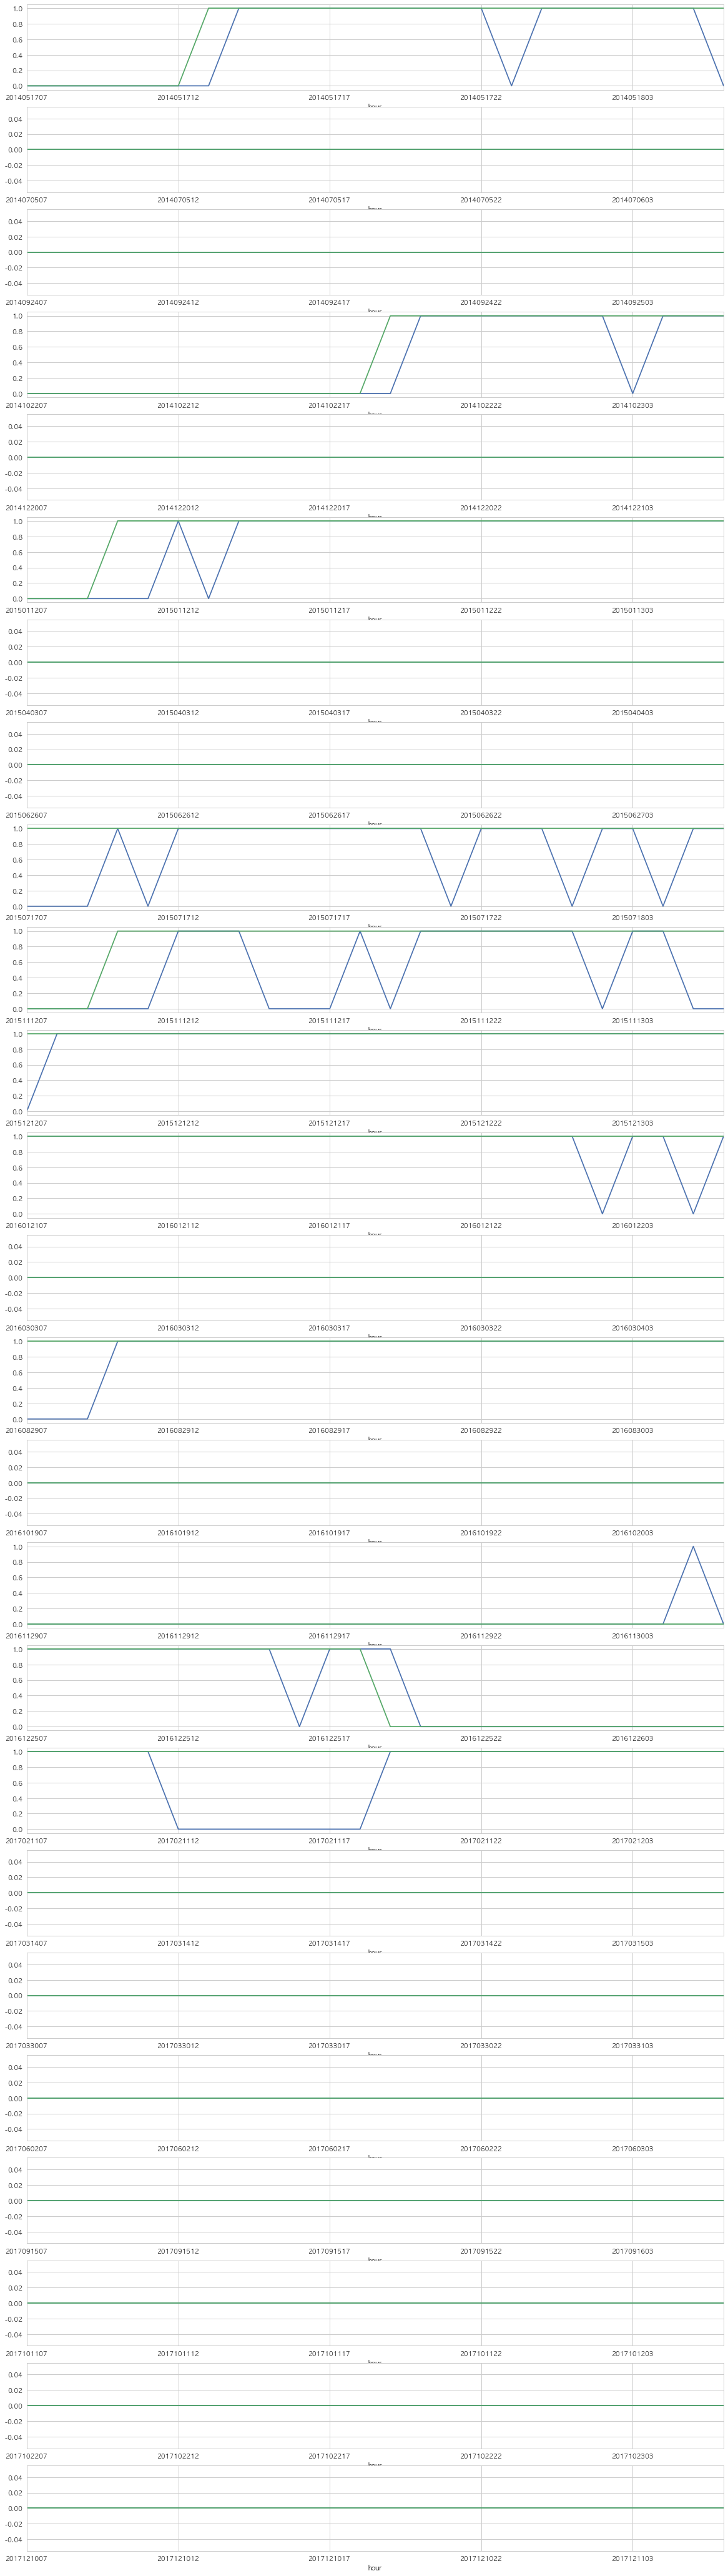

In [116]:
index = 0
for i in range(25):
    index = i*24
    plt.subplot(25,1,i+1)
    test.iloc[index:index+24]['pred_swell'].plot()
    real.iloc[index:index+24].plot()#.apply(lambda x:output_change(x)).plot()

In [117]:
index=0
test.iloc[index:index+24].T

hour,2014051707,2014051708,2014051709,2014051710,2014051711,2014051712,2014051713,2014051714,2014051715,2014051716,...,2014051721,2014051722,2014051723,2014051800,2014051801,2014051802,2014051803,2014051804,2014051805,2014051806
swell,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
pred,0,0,0,0,0,0,0,1,1,1,...,1,1,0,1,1,1,1,1,1,0
proba,"[0.926666666667, 0.0733333333333]","[0.946666666667, 0.0533333333333]","[0.92, 0.08]","[0.926666666667, 0.0733333333333]","[0.873333333333, 0.126666666667]","[0.86, 0.14]","[0.953333333333, 0.0466666666667]","[0.48, 0.52]","[0.34, 0.66]","[0.286666666667, 0.713333333333]",...,"[0.313333333333, 0.686666666667]","[0.34, 0.66]","[0.573333333333, 0.426666666667]","[0.426666666667, 0.573333333333]","[0.36, 0.64]","[0.22, 0.78]","[0.366666666667, 0.633333333333]","[0.34, 0.66]","[0.413333333333, 0.586666666667]","[0.66, 0.34]"
pred_swell,0,0,0,0,0,0,0,1,1,1,...,1,1,0,1,1,1,1,1,1,0
real_swell,0,0,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [118]:
#eval_metric = evaluation(df['swell(t+1)'].apply(output_change))
eval_metric = evaluation(df['swell(t+1)'].fillna(method='ffill'))

In [119]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test['pred_swell'][st:st + 24]))
    #print(test['pred_swell'][st:st+24].value_counts())

print(scores)

0
2    15
1     5
0     4
dtype: int64
24
1    24
dtype: int64
48
1    24
dtype: int64
72
1    11
2    10
0     3
dtype: int64
96
1    24
dtype: int64
120
 2    18
 0     3
 1     2
-2     1
dtype: int64
144
1    24
dtype: int64
168
1    24
dtype: int64
192
 2    17
 0     6
-2     1
dtype: int64
216
 2    12
 0     9
 1     2
-2     1
dtype: int64
240
2    23
0     1
dtype: int64
264
2    22
0     2
dtype: int64
288
1    24
dtype: int64
312
 2    21
 0     2
-2     1
dtype: int64
336
1    24
dtype: int64
360
 1    23
-1     1
dtype: int64
384
1    11
2    10
0     3
dtype: int64
408
 2    17
 0     4
-2     3
dtype: int64
432
1    24
dtype: int64
456
1    24
dtype: int64
480
1    24
dtype: int64
504
1    24
dtype: int64
528
1    24
dtype: int64
552
1    24
dtype: int64
576
1    24
dtype: int64
[35, 24, 24, 31, 24, 36, 24, 24, 32, 24, 46, 44, 24, 40, 24, 22, 31, 28, 24, 24, 24, 24, 24, 24, 24]


In [120]:
np.sum(scores)

705

In [121]:
imp_features

[['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_습도(%)',
  '22105_기온(°C)',
  '22106_기온(°C)',
  '22106_유의파고(m)',
  '22453_유의파고(m)',
  '21229_파향(deg)',
  '22106_파주기(sec)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22453_유의파고(m)',
  '22106_습도(%)',
  '22106_유의파고(m)',
  '22106_기온(°C)',
  '21229_수온(°C)',
  '21229_파향(deg)',
  '22105_습도(%)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '22106_습도(%)',
  '21229_기온(°C)',
  '22106_기온(°C)',
  '22453_유의파고(m)',
  '21229_파향(deg)',
  '22105_기온(°C)',
  '22453_평균파고(m)',
  '21229_수온(°C)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_기온(°C)',
  '22106_습도(%)',
  '22106_유의파고(m)',
  '22453_유의파고(m)',
  '21229_수온(°C)',
  '22106_파주기(sec)',
  '22105_현지기압(hPa)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '21229_기온(°C)',
  '22106_습도(%)',
  '22453_유의파고(m)',
  '22106_기온(°C)',
  '21229_수온(°C)',
  '22106_유의파고(m)',
  '22105_기온(°C)',
  '21229_파향(deg)'],
 ['22105_수온(°C)',
  '22453_파주기(sec)',
  '22106_기온(°C)',
  '22106_습도(%)

### parameter

| index | n_estimators | fl_score | acc |class2_f1_score| class2_acc | eval_score | detail|
| --- | --- | --- |--- |--- |--- |
|1 | 10 | 89 | 89|93|82|706| [21, 24, 24, 33, 24, 40, 24, 24, 38, 34, 39, 40, 24, 44, 24, 20, 31, 32, 22, 24, 24, 24, 24, 24, 24]|
|2|30|92|92|95.7|89|745|[30, 24, 24, 32, 24, 40, 24, 24, 44, 38, 42, 46, 24, 46, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]|
|3|30|92|92|95.3|88.4|738|[32, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 44, 24, 44, 24, 20, 34, 36, 22, 24, 24, 24, 24, 24, 24]
|4|30|93|93|95.2|88.4|737|[30, 24, 24, 32, 24, 42, 24, 24, 42, 36, 41, 46, 24, 44, 24, 20, 34, 38, 20, 24, 24, 24, 24, 24, 24]
|5|50|92|92|95.0|86.9|730|[23, 24, 24, 29, 24, 40, 24, 24, 42, 36, 43, 46, 24, 44, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]
|6|50|91.8|91.8|95.3|88.4|735|[27, 24, 24, 31, 24, 40, 24, 24, 42, 40, 41, 44, 24, 44, 24, 20, 32, 38, 24, 24, 24, 24, 24, 24, 24]
|7|50|93|93|96|90|744|[33, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 46, 24, 44, 24, 22, 33, 38, 22, 24, 24, 24, 24, 24, 24]
|8|100|93|93|95.7|89.3|744|[26, 24, 24, 33, 24, 40, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 38, 24, 24, 24, 24, 24, 24, 24]
|9|100|93|93|96.8|91.7|750|[29, 24, 24, 33, 24, 42, 24, 24, 44, 36, 46, 46, 24, 44, 24, 22, 34, 38, 24, 24, 24, 24, 24, 24, 24]
|10|100|94|93.9|96.5|92.2|752|[35, 24, 24, 33, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 33, 38, 20, 24, 24, 24, 24, 24, 24]
|11|150|93|93|95.8|90.3|745|[32, 24, 24, 33, 24, 42, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 34, 22, 24, 24, 24, 24, 24, 24]
|12|150|93.6|93.6|96.7|91.3|753|[35, 24, 24, 31, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 34, 36, 24, 24, 24, 24, 24, 24, 24]|
|13|150|93.8|93.8|96.5|91.3|754|[36, 24, 24, 33, 24, 42, 24, 24, 42, 40, 41, 46, 24, 44, 24, 22, 34, 40, 22, 24, 24, 24, 24, 24, 24]
|14|200|92.6|92.6|95.5|88.8|736|[28, 24, 24, 33, 24, 40, 24, 24, 44, 36, 43, 46, 24, 44, 24, 20, 34, 34, 22, 24, 24, 24, 24, 24, 24]
|15|200|94|94|96.8|92.2|756|[35, 24, 24, 33, 24, 42, 24, 24, 44, 40, 45, 46, 24, 44, 24, 22, 33, 36, 24, 24, 24, 24, 24, 24, 24]
|16|200|92.8|92.8|95.7|89.3|741|[34, 24, 24, 33, 24, 40, 24, 24, 44, 40, 41, 46, 24, 44, 24, 22, 33, 30, 22, 24, 24, 24, 24, 24, 24]